# Assignment 4: Machine Learning Fashionista
## Ang Li-Lian

In [1]:
from PIL import Image
from resizeimage import resizeimage
from glob import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Load all the images
women_files = glob(r'C:\Users\lilia\Desktop\CS156\04-1\women\*')
men_files = glob(r'C:\Users\lilia\Desktop\CS156\04-1\men\*')

imSize = (64,64)

flattened = []
# for each image path
for gender in [women_files,men_files]:
    for path in gender:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                img = image.resize(imSize)
                img = list(img.getdata())
                flattened.append(np.array(img).flatten())

label = [0]*len(women_files) +[1]*len(men_files)

In [3]:
# Store images into a data frame
df = pd.DataFrame(data = {"image": flattened, "label":label})

# Split every colour into one column 
colours = [f"Colour {x+1}" for x in range(len(df["image"][0]))]
df[colours]= pd.DataFrame(df["image"].tolist(), index = df.index)
df = df.drop(["image"], axis = 1)

In [4]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("label", axis = 1), df["label"], 
    test_size=0.2, stratify=df["label"] )

# Simple Linear Classifier

I will use logisitc regression to classify each image into women's or men's clothing. Logistic regression works by fitting an 'S' shaped function that gives the probability that an image will be classifed as women's or men's based on the data in the image (ie: the pixel colours). I chose Stochastic Ascent Gradient (SAG) as the solver because it handles high dimensional and large datasets faster than the default solver since it stores the results of each previous computation and uses it to calculate the function.

I will use three-fold cross validation to determine the regularisation term (bigger number means it will be more generalisable, less biased to the training set). Three-fold because we only have a dataset of about 2000 images. So this means that every fold will have about 650 images which is amply large. Since we are interested in the model's ability to correctly classify images for both women's and men's clothing and we have an equal sample of images for women's and men's clothing, we will use accuracy as a metric to determine how well the model works.

In [5]:
# Simple Linear Classifier
@ignore_warnings(category=ConvergenceWarning)
def cv_logistic(x):
    CLF, accuracy = None, 0
    for c in np.arange(1, 5,1):
        clf = LogisticRegression(solver = 'sag', C = c).fit(x, y_train)
        scores = cross_val_score(clf, x, y_train, cv=3, scoring="accuracy")
        if np.mean(scores)>accuracy:
            accuracy = np.mean(scores)
            CLF = clf
    return CLF, accuracy

In [6]:
clf, accuracy = cv_logistic(X_train)
y_pred = clf.predict(X_test)

In [7]:
print(f"Training Accuracy: {accuracy}")
print("\n")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")

Training Accuracy: 0.6107519205169964


Testing Accuracy: 0.6441351888667992


## Training and Testing Errors

The accuracy for testing is higher than training which means that the model does not have high bias and is able to classify unseen images well.

# Principal Component Analysis (PCA)

PCA attempts to separate out the category of images using the components (in this case the red, green or blue value of each the pixels) to determine which of them describe the separation of data best. For each component, it plots a line in space that will maximise the variance meaning that the total distance of the data points will be as far away from the origin as possible. Then, it outputs a sorted list of components by the largest variance. 

The scree plot below shows how much each pixel helps explain the difference between women's and men's clothing. The first two components account for about 50% which is significant considering we have hundreds of components. This reduction in dimensionality makes classifying faster and reduces noise that may come from having so many components.

However, as the scatter plot shows, it will still be difficult to separate out the data given only two features, even if it explains 50% of the variation. There is no clear way to separate them in this extremely low dimension, but perhaps in a higher dimension we will get better results.

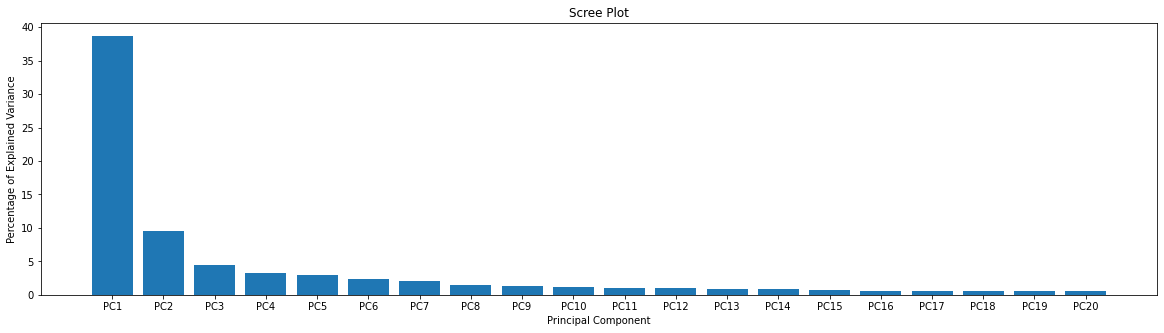

In [8]:
# Make a PCA model
pca = PCA(n_components = 20)
pca.fit(X_train)

# Draw a scree plot and PCA plot
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,5))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

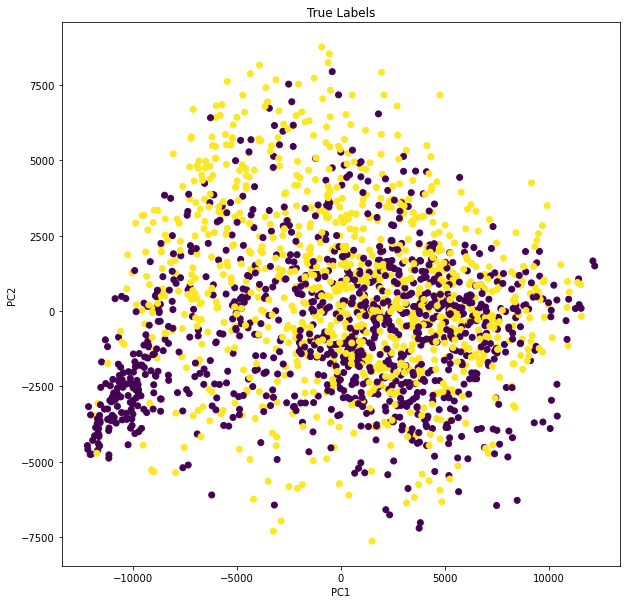

In [9]:
# Visualise split in data
pca_data = pca.transform(X_train)
pca_df = pd.DataFrame(pca_data, columns=labels)

fig = plt.figure(figsize=(10,10))
plt.scatter(pca_df.PC1, pca_df.PC2, c=np.array(y_train))
plt.title("True Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Choosing Parameters

I will use cross-validation to determine how many components to use and what the regularisation term should be for the logisitc regression based on the accuracy score.

In [10]:
@ignore_warnings(category=ConvergenceWarning)
def cv(model):
    C, comp, accuracy = 0,0,0
    for n_comp in np.arange(1,21):
        for c in np.arange(1,5):
            pca = PCA(n_components = n_comp).fit(X_train)
            clf = LogisticRegression(solver = "sag", C= c)
            x = pca.transform(X_train)
            scores = cross_val_score(clf, x, y_train, cv=3, scoring="accuracy")
            if np.mean(scores)> accuracy:
                C, comp = c ,n_comp
                accuracy = np.mean(scores)
    return  accuracy, comp, C

In [11]:
# Select number of components
cross_val = cv(PCA)

# Make a PCA model
pca = PCA(n_components =cross_val[1]).fit(X_train)

# pd.DataFrame(pca.components_, index=X_train.columns)
train =pca.transform(X_train)
test = pca.transform(X_test)

# Simple Linear Classifier
clf = LogisticRegression(solver= "sag", C = cross_val[2]).fit(train, y_train)
y_pred = clf.predict(test)

In [12]:
print(f"Number of components: {cross_val[1]}")
print("\n")
print(f"Training Accuracy: {cross_val[0]}")
print("\n")
print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")

Number of components: 18


Training Accuracy: 0.6575374249827098


Testing Accuracy: 0.6282306163021869


## Training and Testing Errors

The accuracy on the testing data is worse than the training data, and about 2% worse than on logistic regression without transformation. The data was reduced down to 18 components instead of the hundreds in the original data set to get this best accuracy.

# Linear Discriminant Analysis (LDA)

LDA attempts to separate out the categories of images by maximising the distance between the means for women's and men's clothing and minimising the variance between them. Similar to PCA, it does this for each component and can reduce the number of dimensions by selecting the ones with that best explain the data. However, unlike PCA, it takes into account the class labels (which images are women's and men's clothing). 

I use cross-validation here similar with PCA to determine the parameters for number of components and regularisation term for logistic regression

In [13]:
# Make a LDA model
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)

# Transform data
train =lda.transform(X_train)
test = lda.transform(X_test)

# Train Logistic regression
clf, score = cv_logistic(train)
lda_pred = clf.predict(test)

In [14]:
print(f"Training Accuracy: {score}")
print("\n")
print(f"Testing Accuracy: {accuracy_score(y_test, lda_pred)}")

Training Accuracy: 0.9507232150161004


Testing Accuracy: 0.5864811133200796


## Testing and Training Error

There is a huge difference in the accuracy for testing and training which means that the model has too much bias. Even though we performed cross-validation with little variation in their scores, the model still performed poorly on the testing data. 

This might be because when we use LDA to transform the data, brings the data points into a different space and separates them linearly within a high dimensional space, whereas PCA collapses the data down into a lower dimensional space while preserving a high amount of information. Since we are using a linear model to classify the images, PCA's transformation into a lower dimension fits with logistic regression, whereas LDA in its higher dimensional space would suit a nonlinear model better. Alternatively, using LDA as a classifier in itself rather than using logistic regression might have yielded better results.

# Conclusion

The difference between the accuracy score for pure logistic regression and PCA-transformed logistic regression suggests that PCA does not improve the model's predictive ability. However, I would recommend reducing the dimensions of your data before performing a logistic regression because it reduces the time taken to train the model and make predictions. This is especially pertinent when dealing with images with more pixels and larger number of images. It might be worth sacrificing the two percentage points of accuracy if it means getting results in a reasonable waiting time. With a computer with more power, this may not be a concern, so PCA may not be required.

The logistic regression's SAG solver is a better choice than the default in the case of image classification since it is equipped to handle many features and large sample size which will often be the case when dealing with images.

I would also recommend using PCA to transform the data instead of LDA because it performs equally well on the training and testing data. This means that we can have confidence that the model will perform well on unseen images and is a much better predictor than transforming with LDA which has a huge drop in performance when predicting unseen images, a sign of overfitting on the training data.